Created on Monday 11 January 2021

Group 5 - Classification

@authors : F.B

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_feat : pd.DataFrame = pd.read_json('Data_With_Features_Syntax_v1.json')
data = data_feat [['Nb_key_words', 'Nb_key_words_title', 'ratio_key_words', 'ratio_key_word_title','ratio_key_sentences']]
data.index = data_feat.art_id
data.fillna('', inplace=True)
data.head()

,Nb_key_words,Nb_key_words_title,ratio_key_words,ratio_key_word_title,ratio_key_sentences
art_id,,,,,
1,0,0,0.000000,0.000000,0.000000
2,0,0,0.000000,0.000000,0.000000
25,2,0,0.002703,0.000000,0.037037
27,0,1,0.000000,0.076923,0.000000
28,0,0,0.000000,0.000000,0.000000


# Classification

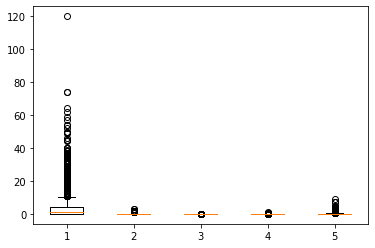

In [4]:
plt.boxplot(data.values)
plt.show()

In [5]:
data.describe()

,Nb_key_words,Nb_key_words_title,ratio_key_words,ratio_key_word_title,ratio_key_sentences
count,7460.000000,7460.000000,7460.000000,7460.000000,7460.000000
mean,3.183780,0.084048,0.006734,0.007702,0.130156
std,5.789337,0.301558,0.012118,0.033911,0.319795
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.002901,0.000000,0.046015
75%,4.000000,0.000000,0.008246,0.000000,0.142857
max,120.000000,3.000000,0.250000,1.000000,9.000000


In [6]:
# Centre and reduce
data_scale = scaler.fit_transform(data)

In [7]:
pca = PCA(n_components=3)
Xp = pca.fit_transform(data_scale)

pca.explained_variance_ratio_.sum()

0.9013664910022112

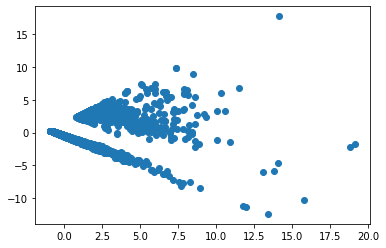

In [8]:
plt.scatter(Xp[:,0],Xp[:,1])
plt.show()

In [9]:
def slope_intercept(A : list, B : list) -> tuple:
  '''This function is used to calculate the steering coefficient and 
     the y-intercept at the origin of a straight line passing through 
     the 2 points passed as a parameter.
     Input : 
      A : point 1
      B : point 2
     Output :
        a : slope
        b : intercept
  '''
  a = ( B[1] - A[1] ) / ( B[0] - A[0] )
  b = A[1] - a * A[0]
  return a,b

def classification_group(E : list) -> float:
  ''' This function calculates the difference between the Y-axis of 
      the point and its Y-axis corresponds to the line
      Input :
        E : point
      Output :
  '''
  a,b = slope_intercept(A2, B2)
  return E[1]-a*E[0]-b

100%|██████████| 7460/7460 [00:00<00:00, 321749.63it/s]


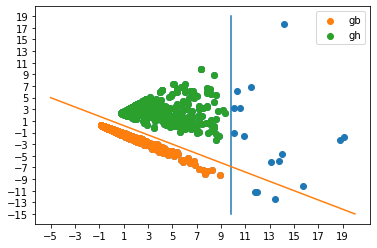

In [10]:
index_group_bottom : list = []
gb : list = []
index_group_top : list = []
gh : list = []
art_id : list = data.index.values.tolist()
A1 :list = [9.8, 19]
B1 :list = [9.8, -15]
A2 :list = [-5, 5]
B2 :list = [ 20, -15]

for i in tqdm(range(Xp.shape[0])) :
  if Xp[i,0]< A1[0] :
    if classification_group(Xp[i,:]) >0 :
      index_group_top.append(art_id[i])
      gh.append(i)
    else :
      index_group_bottom.append(art_id[i])
      gb.append(i)   


plt.scatter(Xp[:,0],Xp[:,1])
plt.scatter(Xp[gb,0],Xp[gb,1], label='gb')
plt.scatter(Xp[gh,0],Xp[gh,1], label='gh')
plt.plot([A1[0], A1[0]],[A1[1],B1[1]])
plt.plot([A2[0], B2[0]], [A2[1], B2[1]])

plt.xticks(range(-5, 21, 2))
plt.yticks(range(-15, 21, 2))
plt.legend()
plt.show()

In [11]:
len(index_group_top), len(index_group_bottom)

(564, 6880)

# Labeling

In [12]:
# We retrieve the id's of items that we are sure are non-innovative.
dff = data[data['Nb_key_words']==0]
dff = dff[dff['Nb_key_words_title']==0]
art_ids = dff.index.values.tolist()

len(art_ids)

2815

In [13]:
# Determine which group its non-innovative products belong to 

print("The percentage of articles in common of the non-innovative articles \nand that of the group in orange :", 100*len(set(art_ids).intersection(set(index_group_bottom)))/len(art_ids),"%")
print("The percentage of articles in common of the non-innovative articles \nand that of the group in vert :", 100*len(set(art_ids).intersection(set(index_group_top)))/len(art_ids),"%")

The percentage of articles in common of the non-innovative articles 
and that of the group in orange : 100.0 %
The percentage of articles in common of the non-innovative articles 
and that of the group in vert : 0.0 %


In [14]:
data_scale = pd.DataFrame(data_scale, columns=data.columns, index = data.index)

data_scale['label_innovation'] = -1 # unknown
data_scale.loc[index_group_bottom,'label_innovation'] = 0 # No innovation
data_scale.loc[index_group_top,'label_innovation'] = 1 # Innovation

In [15]:
train = data_scale[data_scale['label_innovation']!=-1]
X = train[['Nb_key_words','Nb_key_words_title','ratio_key_words','ratio_key_word_title','ratio_key_sentences']].values
y = train.label_innovation.values 

In [16]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);

logit
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------
rf
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------


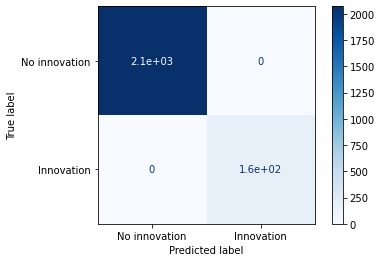

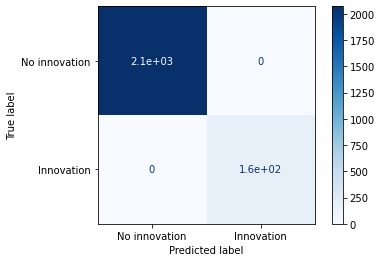

In [17]:
models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier()
}

for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [18]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------
rf
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------


In [19]:
# Here, we are on the labeling made is exact.

# Prediction label unknow

In [21]:
test = data_scale [data_scale['label_innovation']==-1]
X_test = test[['Nb_key_words','Nb_key_words_title','ratio_key_words','ratio_key_word_title','ratio_key_sentences']].values

In [22]:
# Regression logistic

model = LogisticRegression()
model.fit(X,y)
y_pred_rl= model.predict(X_test)

In [23]:
# Random forest

model = RandomForestClassifier()
model.fit(X,y)
X_test = test[['Nb_key_words','Nb_key_words_title','ratio_key_words','ratio_key_word_title','ratio_key_sentences']].values
y_pred_rf= model.predict(X_test)

In [24]:
print('f1_score : ', f1_score(y_pred_rf, y_pred_rl))

z=y_pred_rf-y_pred_rl
print('accuracy :', len(z[z==0])/len(z))

f1_score :  1.0
accuracy : 1.0


# Output 

In [25]:
df_pred = pd.DataFrame( y_pred_rf, columns=['label_innovation'], index = test.index)
df_pred.head()

,label_innovation
art_id,
850,1
1330,1
1357,0
1484,0
1711,1


In [26]:
label=train[['label_innovation']]
label=label.append(df_pred)
label.sort_index(inplace=True)
label.head()

,label_innovation
art_id,
1,0
2,0
25,0
27,1
28,0


In [27]:
data_scale.head()

,Nb_key_words,Nb_key_words_title,ratio_key_words,ratio_key_word_title,ratio_key_sentences,label_innovation
art_id,,,,,,
1,-0.549975,-0.278732,-0.555703,-0.227153,-0.407026,0
2,-0.549975,-0.278732,-0.555703,-0.227153,-0.407026,0
25,-0.204490,-0.278732,-0.332660,-0.227153,-0.291203,0
27,-0.549975,3.037600,-0.555703,2.041374,-0.407026,1
28,-0.549975,-0.278732,-0.555703,-0.227153,-0.407026,0


In [28]:
# Ensuring that the labelling is accurate  
y = label.label_innovation
X = data_scale.drop('label_innovation', axis=1)

logit
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------
rf
accuracy ...
1.0
f1_score ...
1.0
----------------------------------------------------


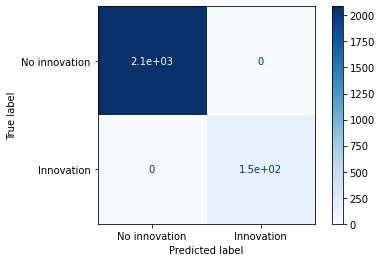

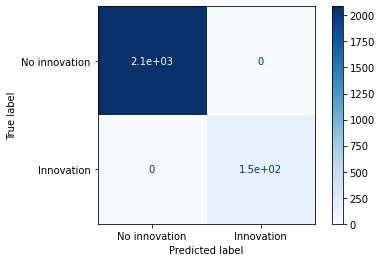

In [29]:
for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [30]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------
rf
accuracy ...
[1. 1. 1. 1. 1.]
f1_score ...
[1. 1. 1. 1. 1.]
----------------------------------------------------


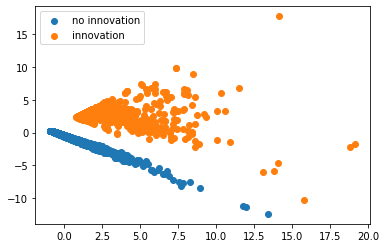

In [31]:
# Overview of innovative and non-innovative articles
index_no_innovation = np.where(y==0)[0].tolist()
index_innovation = np.where(y==1)[0].tolist()

plt.scatter(Xp[index_no_innovation,0],Xp[index_no_innovation,1], label='no innovation')
plt.scatter(Xp[index_innovation,0],Xp[index_innovation,1], label='innovation')
plt.legend()

In [32]:
print('The number of relevant documents :',len(y[y==1]))

The number of relevant documents : 577


In [34]:
label.head()

,label_innovation
art_id,
1,0
2,0
25,0
27,1
28,0


In [35]:
label.to_csv("../Output/Innovation/label_unsupervised_PCA.csv", index=True)